In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import nltk; nltk.download('stopwords')

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models 
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/huiwen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(["palestinianlivesmatter",
                 "israelterrorist""israelterrorists","save_sheikh_jarrah"])

In [3]:
# Read data
df = pd.read_csv('/Users/huiwen/Documents/Side Projects/Omdena/omdena-colombia-socialnetwork/Untitled/src/data/task-2-preprocessing/merged_data/Final/Final_all.csv')
df.head()

,Unnamed: 0,created_at,id_str,conversation_id_str,full_text,twitter_lang,favorited,retweeted,retweet_count,favorite_count,...,preprocessed_data,emoji_list,emoticons_list,filename,preprocessed_data_without_hashtags,data_source,lang,score,langTb,lang_langdetect
0,0,2021-03-27T04:09:42+00:00,1.375661e+18,1.375265e+18,@Diputado_Canelo Hagamos otro por el uno de ma...,es,False,False,0.0,1.0,...,"['hacer', 'mayo', 'cazar', 'fantasma', 'mayo']",[''],[':/'],Mayo_SPANISH_tweets_stweet.csv,"['hacer', 'mayo', 'cazar', 'fantasma']",Twitter,es,NaN,NaN,NaN
1,1,2021-03-22T21:12:09+00:00,1.374107e+18,1.374107e+18,Después de esperar con ancias el #28F ahora es...,es,False,False,1.0,4.0,...,"['despues', 'esperar', 'ancia', 'ahora', 'espe...",['💙🤍💙'],[],Mayo_SPANISH_tweets_stweet.csv,"['despues', 'esperar', 'ancia', 'ahora', 'espe...",Twitter,es,NaN,NaN,NaN
2,2,2021-03-22T12:30:53+00:00,1.373975e+18,1.373975e+18,Espero que ésto llegue hasta oídos de la nueva...,es,False,False,0.0,1.0,...,"['esperar', 'llegar', 'oido', 'nuevo', 'inicia...",[''],[],Mayo_SPANISH_tweets_stweet.csv,"['esperar', 'llegar', 'oido', 'nuevo', 'inicia...",Twitter,es,NaN,NaN,NaN
3,3,2021-04-04T12:56:55+00:00,1.378693e+18,1.378693e+18,A menos de un mes del #1Mayo Urkullu teme perd...,es,False,False,3.0,5.0,...,"['menos', 'mes', 'mayo', 'urkullu', 'temer', '...",[''],[],Mayo_SPANISH_tweets_stweet.csv,"['menos', 'mes', 'urkullu', 'temer', 'perder',...",Twitter,es,NaN,NaN,NaN
4,4,2021-04-03T20:14:57+00:00,1.378441e+18,1.378441e+18,La X Edición del Festival Internacional Un Pue...,es,False,False,1.0,3.0,...,"['edicion', 'festival', 'internacional', 'puen...",[''],"[':/', ':/']",Mayo_SPANISH_tweets_stweet.csv,"['edicion', 'festival', 'internacional', 'puen...",Twitter,es,NaN,NaN,NaN


In [4]:
# processed list of words to str
df['preprocessed_str_without_hashtags'] = df['preprocessed_data_without_hashtags'].apply(eval).apply(' '.join)
# df.head()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
#         print(sentence)

data = df.preprocessed_str_without_hashtags.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:2])

[['hacer', 'mayo', 'cazar', 'fantasma'], ['despues', 'esperar', 'ancia', 'ahora', 'esperar', 'despues', 'ser', 'inmagino', 'celebracion', 'ano', 'independencia', 'patria', 'ahora', 'si', 'jubil', 'ser', 'verdadero', 'libertad']]


### Bigram and Trigram Models

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [6]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [7]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, verb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:2])

[[], ['despue', 'despue', 'ser', 'celebracion', 'verdadero']]


### Date Transformation -  Corpus for needed for Topic Modelling

In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:2])

[[], [(0, 1), (1, 2), (2, 1), (3, 1)]]


In [9]:
id2word[0]
# corpus[:1][0][:10]

'celebracion'

In [10]:
# Readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:3]]

[[],
 [('celebracion', 1), ('despue', 2), ('ser', 1), ('verdadero', 1)],
 [('dinero', 1),
  ('iniciar', 1),
  ('joven', 1),
  ('laboral', 1),
  ('ojalar', 1),
  ('partir', 1),
  ('programa', 1),
  ('proximo', 1),
  ('ver', 1)]]

### Building Topic Model

In [11]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [12]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.056*"video" + 0.029*"idea" + 0.021*"cop" + 0.020*"pension" + '
  '0.019*"balance" + 0.019*"check" + 0.017*"crisis" + 0.015*"region" + '
  '0.014*"horrible" + 0.014*"top"'),
 (1,
  '0.042*"kill" + 0.035*"time" + 0.023*"day" + 0.022*"debt" + 0.018*"duque" + '
  '0.018*"point" + 0.018*"work" + 0.015*"new" + 0.015*"social" + '
  '0.012*"problem"'),
 (2,
  '0.218*"colombian" + 0.073*"stop" + 0.039*"system" + 0.033*"account" + '
  '0.030*"care" + 0.028*"medium" + 0.024*"policy" + 0.020*"petro" + '
  '0.017*"learn" + 0.016*"favor"'),
 (3,
  '0.049*"people" + 0.029*"government" + 0.019*"protest" + 0.018*"tax" + '
  '0.015*"say" + 0.015*"get" + 0.014*"make" + 0.012*"right" + 0.012*"even" + '
  '0.012*"thing"'),
 (4,
  '0.111*"go" + 0.059*"help" + 0.051*"need" + 0.015*"criminal" + '
  '0.014*"control" + 0.014*"put" + 0.010*"cost" + 0.009*"personal" + '
  '0.008*"open" + 0.008*"break"'),
 (5,
  '0.083*"country" + 0.067*"police" + 0.043*"see" + 0.032*"good" + '
  '0.030*"happen" + 0.022*

### Compute Model Perplexity and Coherance Score

In [13]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is, lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.868331780080144

Coherence Score:  0.4447453430512113


### Visualise Topic Keywords

In [14]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.297792  0.066836       1        1  30.025482
1      0.108522 -0.055839       2        1  14.454893
7     -0.002650 -0.077858       3        1  12.198371
5      0.113941  0.086454       4        1  12.104993
4      0.009159 -0.088870       5        1  10.252750
6     -0.153495 -0.132855       6        1   9.261813
0     -0.170340 -0.075504       7        1   6.466308
2     -0.202929  0.277635       8        1   5.235389, topic_info=                     Term         Freq        Total Category  logprob  loglift
1877            colombian  1235.000000  1235.000000  Default  30.0000  30.0000
828                    go  1236.000000  1236.000000  Default  29.0000  29.0000
1555              country  1082.000000  1082.000000  Default  28.0000  28.0000
4189               people  1587.000000  1587.000000  Default  27.0000  27.0000
7745               police   884.000000   884.000000  Default  26.0000  26.0000
...                   ...          ...          ...      ...      ...      ...
10013          difference    14.213836    52.300670   Topic8  -5.9875   1.6469
10960  government_promote    11.779413    34.174547   Topic8  -6.1753   1.8846
8973              citizen    14.784994   144.710059   Topic8  -5.9481   0.6686
9606           healthcare    13.282006    76.649345   Topic8  -6.0553   1.1969
10549              oppose    11.763894   136.961120   Topic8  -6.1767   0.4951

[405 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2571      8  0.996155  account
8885      1  0.064441      act
8885      2  0.072497      act
8885      3  0.056386      act
8885      4  0.716911      act
...     ...       ...      ...
8998      5  0.629321    write
8998      7  0.048409    write
7013      1  1.000154    wrong
6996      1  0.996629     year
2160      7  0.991629  youtube

[986 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 8, 6, 5, 7, 1, 3])

### Building LDA Mallet Model

In [15]:
# !curl http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip — output mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip

In [16]:
## Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/huiwen/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word) # latest gensim not supported, use 3.8.3

Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 473
total tokens: 100560
<10> LL/token: -9.94924
<20> LL/token: -9.58949
<30> LL/token: -9.40776
<40> LL/token: -9.30474

0	6.25	people government protest country tax make happen time good day pay money live bad continue show reform year debt increase 
1	6.25	ver duque gobierno hacer ir todo joven nacional popular gente mas dictadura si petro apoyar trave querer eleccion mejor demand 
2	6.25	police kill social protester violence shoot colombian stop civilian please_help state joven city narco resistir muerte duque citizen share video 
3	6.25	colombian thing murder world matar stamp video lot call president ciudadano favor problem poor uribe primero_linea protest act link uribista 
4	6.25	amp estar politico colombio asesinar trabajo partido today actual work tax_reform querer persona exigir llevar ciudad asi paro ayuda movilizacion 
5	6.25	paro nacional calle pueblo attack gente vida trabajar criminal ser deber 

<360> LL/token: -8.93506
<370> LL/token: -8.9435
<380> LL/token: -8.94382
<390> LL/token: -8.9363

0	6.25	people country tax make government time thing good pay money bad lot reform year give debt work tax_reform increase month 
1	6.25	gobierno duque social apoyar vida dar mejor favor vivo presidente manifestacion lider petro uribismo muerte grande millon propio accion meter 
2	6.25	police people kill colombian video amp protester violence shoot day stop murder happen civilian please_help colombia force live share young 
3	6.25	protest government colombian state world attack real continue call president social fight find leave talk idea street power fuck group 
4	6.25	estar todo joven hablar gracia civil ciudad asesinar partido criminal narco matar popular stamp destruir trabajo disparar asesino exigir esperar 
5	6.25	paro nacional colombio calle pueblo vida despue vivir defender criminal dictadura masacre fuerza represion protesta comite movilizacion fuerza_publicar gran quedar 
6	6.2

<710> LL/token: -8.92355
<720> LL/token: -8.92667
<730> LL/token: -8.92681
<740> LL/token: -8.92547

0	6.25	people country tax make government time thing good pay money bad lot reform year give debt tax_reform work increase high 
1	6.25	gobierno vida duque social apoyar mejor dar favor vivo hacer presidente manifestacion lider petro muerte uribismo grande trave millon propio 
2	6.25	police people kill video amp protester violence shoot day murder colombian attack civilian stop please_help colombia force show city share 
3	6.25	protest government colombian happen state social world real continue today call president fight find leave street fuck power group uribe 
4	6.25	estar todo joven hablar matar criminal gracia civil asesinar ciudad tocar ciudadano stamp popular destruir trabajo disparar total asesino exigir 
5	6.25	paro nacional colombio calle pueblo despue dictadura vivir volver defender fuerza masacre protesta represion comite movilizacion internacional gran salir derecho 
6	6.25

In [17]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('people', 0.02767765190525232),
   ('country', 0.02452368692070031),
   ('tax', 0.015834191555097837),
   ('government', 0.015126158599382081),
   ('make', 0.014225025746652934),
   ('time', 0.010942327497425335),
   ('thing', 0.010298661174047374),
   ('good', 0.010234294541709578),
   ('pay', 0.00952626158599382),
   ('money', 0.00952626158599382)]),
 (1,
  [('gobierno', 0.05409974640743871),
   ('duque', 0.036179205409974644),
   ('vida', 0.034911242603550295),
   ('social', 0.024429416737109046),
   ('criminal', 0.020794590025359255),
   ('dar', 0.019357565511411667),
   ('mejor', 0.01749788672865596),
   ('favor', 0.01699070160608622),
   ('apoyar', 0.01639898562975486),
   ('vivo', 0.015215553677092139)]),
 (2,
  [('police', 0.047619047619047616),
   ('kill', 0.032134532134532136),
   ('video', 0.02206127206127206),
   ('people', 0.020146520146520148),
   ('amp', 0.017649017649017648),
   ('protester', 0.015068265068265068),
   ('shoot', 0.014485514485514486),
   ('day',

### Finding Optimal Number of topics for LDA

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=20, step=6)

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 473
total tokens: 100560
<10> LL/token: -9.11779
<20> LL/token: -9.02079
<30> LL/token: -8.9537
<40> LL/token: -8.89531

0	25	people government protest colombian kill country duque police gobierno tax make nacional happen favor paro querer violence time thing good 
1	25	ver hacer poder gente ir estar ser gobierno vida persona colombio querer si todo social joven solo calle paro video 

<50> LL/token: -8.85311
<60> LL/token: -8.8183
<70> LL/token: -8.79942
<80> LL/token: -8.78562
<90> LL/token: -8.76747

0	25	people government police colombian protest duque kill country social tax make amp favor happen violence time criminal thing good day 
1	25	ver hacer poder gobierno ir estar querer vida solo paro colombio nacional gente ser todo persona si joven mas video 

<100> LL/token: -8.75162
<110> LL/token: -8.74014
<120> LL/token: -8.73318
<130> LL/token: -8.7263
<140> LL/token: -8.72381

0	25	people government police 

<50> LL/token: -9.22206
<60> LL/token: -9.16796
<70> LL/token: -9.13048
<80> LL/token: -9.10079
<90> LL/token: -9.08583

0	6.25	calle pueblo hacer vivo quedar gracia responder ciudad joven si criminal disparar muerte grande gobierno ir parecer accion pue entender 
1	6.25	estar colombio duque vida video dictadura desaparecido narco masacre todo give actual fuerza_publicar despue necesitar joven por protestar volver pandemic 
2	6.25	people police colombian protest government kill protester violence shoot good pay murder state attack show call work month fight find 
3	6.25	persona ser querer poder mas acabar matar defender dinero gobierno existir tocar sacar meno presidente necesitar millon vida trabajar ocurrir 
4	6.25	solo ver poder hablar hacer mejor parte entonce problema si pensar dar creer situacion gobierno civil dejar stamp trabajo please_help 
5	6.25	country tax make happen people government time thing day stop money live bad world civilian lot continue today president reform 
6	

<410> LL/token: -8.95811
<420> LL/token: -8.95802
<430> LL/token: -8.95401
<440> LL/token: -8.95396

0	6.25	gobierno calle pueblo criminal vivo gracia quedar ciudad entender responder manifestacion bajo colombia pandemia disparar esperar muerte grande trave accion 
1	6.25	estar duque colombio joven video vida todo dictadura volver desaparecido narco masacre represion total fuerza_publicar por violacion protestar uribista denunciar 
2	6.25	police people colombian protest kill government protester violence shoot stop murder state attack happen civilian continue today show call force 
3	6.25	persona mas ser necesitar trabajar vivir vida defender tocar poder dinero existir poner trabajo presidente meno ciudadano millon parte propio 
4	6.25	ver hacer solo si hablar poder mejor dar situacion dejar todo igual despue entonce asi pensar parte peor please_help gran 
5	6.25	people country government tax make time thing good day pay money bad world lot president reform year work give debt 
6	6.25	

	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)
type: 193 new topic: 7
5:2 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)
type: 5891 new topic: 0
1:3 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at 

<770> LL/token: -8.93645
<780> LL/token: -8.93688
<790> LL/token: -8.93506

0	6.25	gobierno calle pueblo criminal gracia ciudad venir destruir ciudadano colombia esperar uribismo pandemia exigir muerte grande trave salir responsable accion 
1	6.25	estar duque vida colombio joven video todo dictadura civil volver desaparecido narco masacre represion manifestacion total asesinar fuerza_publicar disparar por 
2	6.25	people police colombian protest kill government protester violence shoot day stop murder state attack civilian happen continue today show call 
3	6.25	persona gente mas solo parte ser todo necesitar vivir trabajar dinero tocar defender poner trabajo bajo meno millon resistir derecho 
4	6.25	ver hacer poder si hablar dar mejor situacion entonce dejar igual despue solo asi pensar entender peor please_help responder sacar 
5	6.25	country government people tax make time thing good pay money bad world lot president reform year give debt work tax_reform 
6	6.25	ir querer poder polit

<60> LL/token: -9.37901
<70> LL/token: -9.33248
<80> LL/token: -9.30366
<90> LL/token: -9.27551

0	3.57143	hacer gobierno poder si mejor asi ver persona dinero tocar meno sector grande comite gente querer llegar quedar ir educacion 
1	3.57143	hablar ver gobierno calle vivo joven terminar manifestacion destruir pandemia venir mismo exigir situacion protestar detener reforma_tributario acabar perder entender 
2	3.57143	people government colombian tax pay reform president tax_reform month point poor uribe protestor end pandemic group understand public leave democracy 
3	3.57143	hacer joven corrupcion dejar parte ir vivir ciudadano entonce peor please_help gran fuerza_publicar uribismo salir estar eleccion pagar mas ver 
4	3.57143	paro nacional estar asesinar matar desaparecido presidente trabajo movilizacion protesta trave persona todo gracia parte entender entonce vario igual denunciar 
5	3.57143	vida ir pueblo apoyar trabajar mas defender favor stamp solo poder propio dar llevar todo se

<260> LL/token: -9.14633
<270> LL/token: -9.14588
<280> LL/token: -9.13972
<290> LL/token: -9.13428

0	3.57143	hacer poder querer si ir mejor ver necesitar asi tocar gobierno gente sacar terminar grande comite sector llegar educacion buen 
1	3.57143	gobierno joven hablar acabar corrupcion calle volver venir pandemia exigir millon mismo meter derecho manifestacion detener protestar robar perder fin 
2	3.57143	people government tax colombian time president reform tax_reform increase month leave poor pay point pandemic live public understand rich money 
3	3.57143	ver mas parte entonce quedar vivir despue dejar dinero existir peor please_help accion salir eleccion marcha pagar mucho hacer sistema 
4	3.57143	estar paro nacional matar vivo gracia desaparecido calle protesta trabajo asesinar movilizacion gran contar violacion entender internacional paramilitar donde investigacion 
5	3.57143	persona vida dar apoyar solo pueblo favor todo trabajar hacer defender destruir poner propio llevar ata

<460> LL/token: -9.09321
<470> LL/token: -9.08904
<480> LL/token: -9.09618
<490> LL/token: -9.09369

0	3.57143	querer poder hacer si ir mejor necesitar asi tocar sacar solo grande eleccion buen educacion voto publico posible comer pasar 
1	3.57143	gobierno joven hablar corrupcion acabar volver venir manifestacion pandemia mismo exigir meter millon derecho robar protestar detener terminar reforma_tributario uribista 
2	3.57143	people tax government colombian time reform tax_reform increase month leave poor long protestor live president pandemic political rich fact democracy 
3	3.57143	ver mas parte entonce dejar quedar dinero despue existir trabajo peor please_help meno fuerza_publicar accion sistema udo pagar suppo_add salir 
4	3.57143	estar paro nacional calle matar vivo vivir desaparecido protesta comite movilizacion gran internacional marcha violacion contar donde investigacion twitter dialogo 
5	3.57143	persona hacer vida apoyar favor solo dar trabajar situacion defender destruir p

<660> LL/token: -9.09159
<670> LL/token: -9.09008
<680> LL/token: -9.09661
<690> LL/token: -9.08787

0	3.57143	querer hacer poder si mejor solo necesitar asi tocar entender sacar terminar grande llegar educacion eleccion buen voto publico posible 
1	3.57143	gobierno ir joven hablar acabar corrupcion volver venir siempre manifestacion pandemia mismo millon derecho robar detener protestar meter perder uribista 
2	3.57143	people government tax colombian time reform thing tax_reform leave poor long president pandemic pay political point rich fact democracy car 
3	3.57143	ver mas parte entonce hacer video quedar dejar dinero despue existir trabajo peor please_help meno accion fuerza_publicar poco mucho pagar 
4	3.57143	estar paro nacional calle matar vivo vivir desaparecido protesta comite movilizacion gran contar marcha violacion donde reforma_tributario investigacion dialogo familiar 
5	3.57143	vida persona apoyar dar favor trabajar solo defender todo situacion poner destruir ayuda propio

<860> LL/token: -9.07644
<870> LL/token: -9.08402
<880> LL/token: -9.0791
<890> LL/token: -9.07891

0	3.57143	querer hacer poder si mejor necesitar solo tocar entender sacar grande llegar educacion buen voto publico posible eleccion comer meno 
1	3.57143	gobierno ir hablar acabar corrupcion volver venir manifestacion pandemia terminar mismo derecho siempre robar millon protestar meter perder peor iniciar 
2	3.57143	people government tax colombian time president reform tax_reform month leave poor thing long year pandemic political rich fact family system 
3	3.57143	ver mas parte dejar entonce quedar dinero despue video existir trabajo please_help fuerza_publicar salir poco pagar peor clase vandalismo claro 
4	3.57143	estar nacional paro calle matar vivo vivir desaparecido protesta comite movilizacion gran marcha contar violacion reforma_tributario muerto donde internacional twitter 
5	3.57143	persona hacer solo dar apoyar vida favor trabajar asi defender pue responder poner destruir ayu

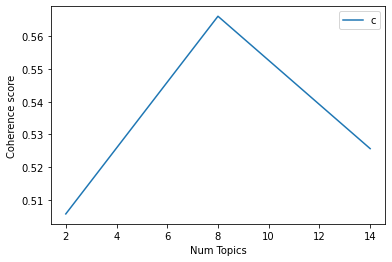

In [27]:
# Show graph
limit=20; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [28]:
# Select the model and print the topics
optimal_model = ldamallet
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.028*"people" + 0.025*"country" + 0.016*"tax" + 0.015*"government" + '
  '0.014*"make" + 0.011*"time" + 0.010*"thing" + 0.010*"good" + 0.010*"pay" + '
  '0.010*"money"'),
 (1,
  '0.054*"gobierno" + 0.036*"duque" + 0.035*"vida" + 0.024*"social" + '
  '0.021*"criminal" + 0.019*"dar" + 0.017*"mejor" + 0.017*"favor" + '
  '0.016*"apoyar" + 0.015*"vivo"'),
 (2,
  '0.048*"police" + 0.032*"kill" + 0.022*"video" + 0.020*"people" + '
  '0.018*"amp" + 0.015*"protester" + 0.014*"shoot" + 0.013*"day" + '
  '0.013*"stop" + 0.012*"violence"'),
 (3,
  '0.040*"colombian" + 0.036*"protest" + 0.027*"government" + 0.021*"people" + '
  '0.015*"happen" + 0.010*"state" + 0.009*"world" + 0.009*"real" + '
  '0.008*"continue" + 0.008*"show"'),
 (4,
  '0.039*"estar" + 0.030*"todo" + 0.027*"joven" + 0.019*"hablar" + '
  '0.015*"matar" + 0.014*"gracia" + 0.013*"civil" + 0.012*"desaparecido" + '
  '0.011*"asesinar" + 0.011*"ciudad"'),
 (5,
  '0.038*"paro" + 0.038*"nacional" + 0.033*"colombio" + 0.022*"cal

### Finding dominant topic in each sentence

In [29]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.1250,"people, country, tax, government, make, time, ...",hacer mayo cazar fantasma
1,1,5.0,0.1682,"paro, nacional, colombio, calle, pueblo, dicta...",despues esperar ancia ahora esperar despues se...
2,2,5.0,0.1681,"paro, nacional, colombio, calle, pueblo, dicta...",esperar llegar oido nuevo iniciar laboral part...
3,3,1.0,0.1467,"gobierno, duque, vida, social, criminal, dar, ...",menos mes urkullu temer perder control dar pas...
4,4,6.0,0.1422,"poder, persona, ser, mas, hacer, politico, cor...",edicion festival internacional puente hacia ce...
5,5,0.0,0.1250,"people, country, tax, government, make, time, ...",cgt celebrar mayo hostigamiento sufrido empresa
6,6,6.0,0.1544,"poder, persona, ser, mas, hacer, politico, cor...",cgt celebrar acto central primero mayo
7,7,4.0,0.1422,"estar, todo, joven, hablar, matar, gracia, civ...",conmemorar dia internacional trabajador ocasio...
8,8,0.0,0.1250,"people, country, tax, government, make, time, ...",pasado puente san jose pasado semana santo abe...
9,9,2.0,0.1442,"police, kill, video, people, amp, protester, s...",pascua resurreccion domingo posterior primero ...


In [30]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7925,"people, country, tax, government, make, time, ...",painting austerity bad word problem always use...
1,1.0,0.3066,"gobierno, duque, vida, social, criminal, dar, ...",papito salir falsedad creer duque invento sabe...
2,2.0,0.3876,"police, kill, video, people, amp, protester, s...",shoot live lethal round footage think I see so...
3,3.0,0.5209,"colombian, protest, government, people, happen...",agree material condition create colombian gove...
4,4.0,0.2621,"estar, todo, joven, hablar, matar, gracia, civ...",exigir respuesta prohibicion arma letal ciudad...
5,5.0,0.3353,"paro, nacional, colombio, calle, pueblo, dicta...",postcomentario ser remover agredir escrito usa...
6,6.0,0.6562,"poder, persona, ser, mas, hacer, politico, cor...",pais sufrir grave crisis economico social azot...
7,7.0,0.4536,"ver, ir, querer, hacer, gente, solo, si, parte...",buen atravesado pecho hacer rato asi suponer m...


In [31]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(20)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"people, country, tax, government, make, time, ...",5064.0,0.2285
1.0,5.0,"paro, nacional, colombio, calle, pueblo, dicta...",3308.0,0.1493
2.0,5.0,"paro, nacional, colombio, calle, pueblo, dicta...",1935.0,0.0873
3.0,1.0,"gobierno, duque, vida, social, criminal, dar, ...",1532.0,0.0691
4.0,6.0,"poder, persona, ser, mas, hacer, politico, cor...",3153.0,0.1423
5.0,0.0,"people, country, tax, government, make, time, ...",2827.0,0.1276
6.0,6.0,"poder, persona, ser, mas, hacer, politico, cor...",2206.0,0.0995
7.0,4.0,"estar, todo, joven, hablar, matar, gracia, civ...",2135.0,0.0963
8.0,0.0,"people, country, tax, government, make, time, ...",NaN,NaN
9.0,2.0,"police, kill, video, people, amp, protester, s...",NaN,NaN
